In [1]:
using Distributions, StatsPlots, StatsBase

In [44]:
algorithm_names = ["Round robin" "Least occupied" "Random" "Random 2"]

function run_test(c::Int, ρ::Float64, T::Int; shedding=Inf)
    nodes_round_robin = zeros(Int, c)
    nodes_least_conn = zeros(Int, c)
    nodes_random = zeros(Int, c)
    nodes_random_2 = zeros(Int, c)

    μ = 10 # requests per step
    arrival_dist = Poisson(μ*ρ*c)
    completion_dist = LogNormal(log(μ)-0.5)#Exponential(10)

    robin = 0

    results = (Int[],Int[],Int[],Int[])

    for t in 1:T
        for n in 1:c
            completions = Int(round(rand(completion_dist)))
            nodes_round_robin[n] -= min(nodes_round_robin[n], completions)
            nodes_least_conn[n] -= min(nodes_least_conn[n], completions)
            nodes_random[n] -= min(nodes_random[n], completions)
            nodes_random_2[n] -= min(nodes_random_2[n], completions)
        end

        arrivals = Int(round(rand(arrival_dist)))
        for i in 1:arrivals
            # Round robin - chooses next server in turn
            j = robin%c+1
            nodes_round_robin[j] += 1
            robin += 1
            
            # Least - choose the node with least elements
            j = argmin(nodes_least_conn)
            nodes_least_conn[j] += 1
            
            # Randomn - choose a random node
            j = rand(1:c)
            nodes_random[j] += 1
            
            # Random-2 - choose the node with least elements from 2 random nodes
            j2 = rand(1:c)
            if nodes_random_2[j] > nodes_random_2[j2]
                nodes_random_2[j2] += 1
            else
                nodes_random_2[j] += 1
            end
        end
        
        for n in 1:c
            nodes_round_robin[n] = min(nodes_round_robin[n], shedding)
            nodes_least_conn[n] = min(nodes_least_conn[n], shedding)
            nodes_random[n] = min(nodes_random[n], shedding)
            nodes_random_2[n] = min(nodes_random_2[n], shedding)
        end

        append!(results[1], nodes_round_robin[1])
        append!(results[2], nodes_least_conn[1])
        append!(results[3], nodes_random[1])
        append!(results[4], nodes_random_2[1])
    end
    results
end

run_test (generic function with 1 method)

In [105]:
Ρ = [0.1;0.25;0.55:0.1:0.96]
results = [run_test(20, ρ, 200_000; shedding=Inf) for ρ in Ρ];

## Histogram

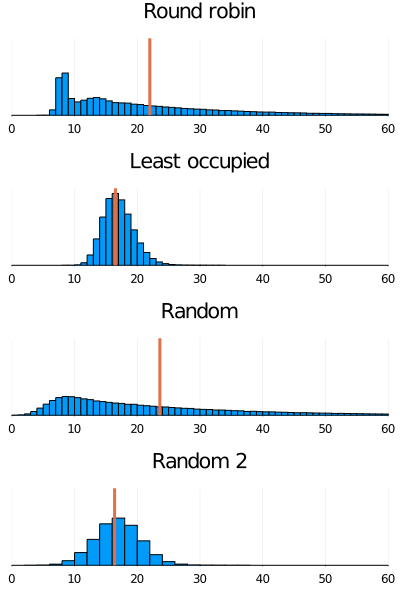

In [106]:
histogram([getfield(results[5],i) for i in 1:4], normed=true, nbins=[200 25 200 30], xlims=(0,60), ylims=(0,0.18), yticks=false, showaxis=:x, leg=:none, size=(400, 600), layout=(4,1), title=algorithm_names, tick_direction=:out, widen=true)
vline!([[mean(getfield(results[5],i))] for i in 1:4], lw=3)

# Over load factor

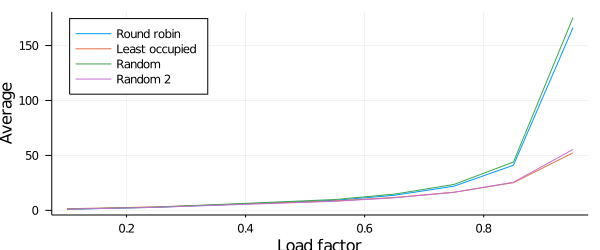

In [107]:
# Mean
μ = [[mean(getfield(results[j],i)) for i in 1:4] for j in 1:length(Ρ)]
plot(Ρ, hcat(μ...)', size=(600,250), label=algorithm_names, leg=:topleft, xaxis="Load factor", yaxis="Average", tick_direction=:out)

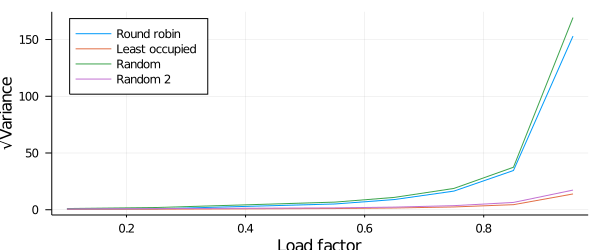

In [108]:
# Standard deviation
σ = [[std(getfield(results[j],i)) for i in 1:4] for j in 1:length(Ρ)]
plot(Ρ, hcat(σ...)', size=(600,250), label=algorithm_names, leg=:topleft, xaxis="Load factor", yaxis="√Variance", tick_direction=:out)

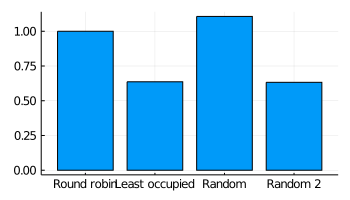

In [109]:
# Entropy
S₀ = entropy(getfield(results[5],1))
plot([entropy(getfield(results[5],i))/S₀ for i in 1:4], seriestype=:bar, xticks=(1:4, algorithm_names), leg=false, size=(350,200))

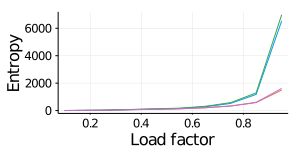

In [110]:
S₀ = entropy(getfield(results[1],1))
S = [[entropy(getfield(results[j],i))/S₀ for i in 1:4] for j in 1:length(Ρ)]
plot(Ρ, hcat(S...)', size=(300,150), label=algorithm_names, leg=:none, xaxis="Load factor", yaxis="Entropy", tick_direction=:out)

# Over cluster size

In [90]:
C = [1:19;20:10:50]
results = [run_test(c, 0.8, 200_000) for c in C];

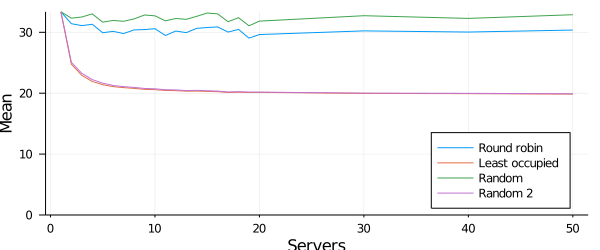

In [93]:
# Mean
μ = [[mean(getfield(results[c],i)) for i in 1:4] for c in 1:length(C)]
plot(C, hcat(μ...)', ylims=(0,NaN), size=(600,250), label=algorithm_names, leg=:bottomright, xaxis="Servers", yaxis="Mean", tick_direction=:out)

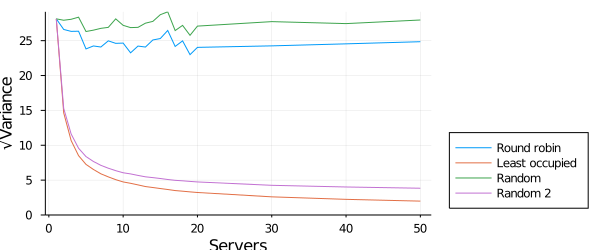

In [94]:
# Standard deviation
σ = [[std(getfield(results[c],i)) for i in 1:4] for c in 1:length(C)]
plot(C, hcat(σ...)', ylims=(0,NaN), size=(600,250), label=algorithm_names, leg=:outerbottomright, xaxis="Servers", yaxis="√Variance", tick_direction=:out)

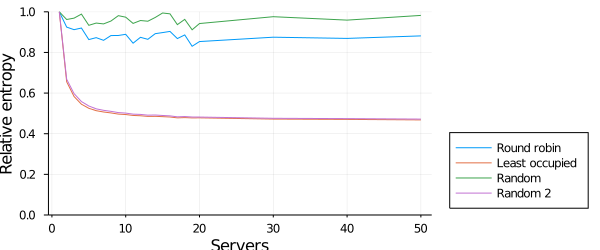

In [103]:
# Entropy
S₀ = entropy(getfield(results[1],1))
S = [[entropy(getfield(results[c],i))/S₀ for i in 1:4] for c in 1:length(C)]
plot(C, hcat(S...)', ylims=(0,NaN), size=(600,250), label=algorithm_names, leg=:outerbottomright, xaxis="Servers", yaxis="Relative entropy", tick_direction=:out)

# Reciprocal of LogNormal
If $X \sim LogNormal(x,1)$ then $\frac{1}{X} \sim LogNormal(-x,1)$ ?

Not exactly by quite close:

In [ ]:
samples = 1.0 ./ rand(LogNormal(log(1)-0.5), 100_000)
histogram(samples, normed=true, xlims=(0,15), bins=400, label="Computed")
plot!(0:0.1:15, LogNormal(-log(1)+0.5), lw=3, label="LogNormal(-x,1)")

# Argument for random-2

Round robin is the default and easiest to understand but the least connections is superior at distributing requests evenly in the face of variable completion times. Least connections have a couble of disadvantages:

1) When a new server comes online it will be overloaded with requests until it comes up to speed. This isn't desirable in our case because of the warmup time of the server.
2) Each load balancer only has a partial view of the upstream servers
3) Least connections is computationally (slightly) more CPU intensive